<a href="https://colab.research.google.com/github/hooymana/ASNR_2025_DataScience/blob/main/script_randomForest_example_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This section takes about 10 minutes to load.<br>
Hit play button for this chunk to have it run in the background while Lei presents.

In [ ]:
#machine learning packages
install.packages("randomForest")
install.packages("tidymodels")
#data manipulation packages
install.packages("dplyr")
install.packages("tidyverse")
#data importing packages
install.packages("curl")
#data visualization packages
install.packages("ggplot2")
install.packages("gghalves")
install.packages("ggExtra")

#running library() loads the installed packages into your connections memory.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(randomForest)
library(curl)
library(ggplot2)
library(gghalves)
library(ggExtra)


**Reading in data from github using curl.** <br>
These data are read in from [this](https://github.com/hooymana/CSM_Data-Visualization_2025) repository. <br>
This way the file doesn't have to be downloaded from a repository and then uploaded into collab.

In [ ]:
url <- "https://raw.githubusercontent.com/hooymana/ASNR_2025_DataScience/main/healthcare-dataset-stroke-data_ASNR.csv"
stroke_data <- read.csv(curl(url),
                 header=TRUE, stringsAsFactors = TRUE,
                 na.strings = c("", "N/A")) %>%
  mutate(stroke = factor(stroke, levels = c("0", "1")))

These data come from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) as part of a stroke prediction challenge.

**Attribute Information** <br>
>1) id: unique identifier <br>
2) gender: "Male", "Female" or "Other" <br>
3) age: age of the patient <br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension <br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease <br>
6) ever_married: "No" or "Yes" <br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed" <br>
8) Residence_type: "Rural" or "Urban" <br>
9) avg_glucose_level: average glucose level in blood <br>
10) bmi: body mass index <br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"* <br>
12) stroke: 1 if the patient had a stroke or 0 if not <br>

In [ ]:
head(stroke_data)

In [ ]:
str(stroke_data)

**Only 4.9% (249/5109) of the participants in these data have a stroke.**

In [ ]:
summary(stroke_data$stroke)

**Let's do some visualizations of the data using GGplot.**<br>
This is rain cloud plot demonstrating the magnitude and distribution of age between people with and without stroke.

In [ ]:
#Rain cloud plot
ggplot(stroke_data,aes(x=stroke,y=age,color=stroke))+
  #geom_half_boxplot(side="l",errorbar.length = 1)+
  geom_half_violin(side="r",show.legend = F)+
  geom_half_boxplot(side="l",show.legend = T)+
  geom_half_dotplot(stackdir = "down",binwidth=1/3,alpha=.25,show.legend = F)+
  xlab("Stroke")+
  ylab("Age (Years)")+
  labs(caption = "0 = No Stroke, 1 = Stroke")+
  coord_flip()

This is a scatter plot between age and average glucose among people with and without stroke.<br>
The trends in this plot represent the linear fit between age and glucose for people with and without stroke.

In [ ]:
#Get the linear trends to get the intercepts and slopes for each group.
#Then we can map a black background line to provide contrast between the trends
# and the data.
summary(lm(avg_glucose_level~age*stroke,stroke_data))

a=ggplot(stroke_data,aes(x=age,y=avg_glucose_level,color=stroke))+
  geom_point(alpha=.1)+ #make invisible points so that ggmarginal works
  geom_point(data=stroke_data[stroke_data$stroke==0,],
mapping=aes(x=age,y=avg_glucose_level),
alpha=.2,color="purple")+ #create points specific to no stroke
    geom_point(data=stroke_data[stroke_data$stroke==1,],
mapping=aes(x=age,y=avg_glucose_level),
alpha=.95,shape=21,stroke=1.5,color="orange")+ #create bolder points specific to stroke
  geom_abline(intercept = 86.4,slope = .44,color="black",size=2.5,alpha=.75)+ #create contrast line for non-stroke
  geom_abline(intercept = 96.6,slope = .53,color="black",size=2.5,alpha=.75)+ #create contrast line for stroke
  geom_smooth(method = "lm",size=1)+ #create linear trends for each group (stroke and non-stroke)
  xlab("Age (Years)")+
  scale_color_manual(values = c("0" = "purple", "1" = "orange"))+ #customize color of trend lines
  theme_classic()+ #make background white
  ylab("Average Glucose Level")

ggMarginal(a,type = "density",groupFill = T) #add the density plots to the x and y axes


You can find more ways to plot in ggplot using this [github repo](https://github.com/hooymana/CSM_Data-Visualization_2025/tree/main).

**Our Research Question** <br>
Can we identify which variables are associated with having a stroke? <br>
<br>
Let's try logistic regression first (remember to remove id variable).

In [ ]:
fit.all = glm(stroke~. -id,stroke_data,family = "binomial")
summary(fit.all)

**Let's make a table to check and interpret results**<br>
<br>
We will need to use the exp() function to convert the coefficients and confidence intervals to Odds Ratios (OR). <br>

OR > 1 represent variables that increase odds of stroke.<br>
OR < 1 represent variables that decrease odds of stroke.<br>
OR = 1 (non-significant) represent neither increase or decrease in odds of stroke.

In [ ]:
coef.vec=round(exp(coef(fit.all)),3)
confint.table=suppressWarnings(round(exp(confint(fit.all)),3))

results.df=data.frame(OR = coef.vec,
lower.CI = confint.table[,1],
upper.CI = confint.table[,2],
p.value = round(coef(summary(fit.all))[,4],3))

results.df

Variables age, hypertension, and average glucose are statistically significant. <br>
<br>
But how well do they classify?<br>
Statistical significance is great but are these results meaningful?

In [ ]:
# Predict on the data
stroke_pred <- ifelse(predict(fit.all, newdata = stroke_data, type = "response") > 0.5, 1, 0)

# Generate a confusion matrix using the training data
table(stroke_data$stroke,stroke_pred)

**Not very good.** <br>
<br>
It is important to remember that these results represent association and not prediction. To get closer to prediction we can perform **cross-validation**.<br>

I am going to create a training set and test set with an equal proportion of people with stroke in both.<br>

It is conventional to have the training data be 80% of the total data and the test data to be 20% of the total data. <br>

This is known as an 80/20 cross-validation split.

In [ ]:
set.seed(123) # Set seed for reproducibility

# Split data into training and testing sets with stratification, the "prop" arguement splits the data into percent training and test we want.
stroke_split <- initial_split(stroke_data, prop = 0.8, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

table(stroke_train$stroke)
table(stroke_test$stroke)

**Now we will *train* our a model with the training data set.**<br>
This will generate a model that has coefficients specific to the training data, but is naive to the test data. <br>
**Then *test* that model on the test set**<br>
Classification accuracy of the trained model on the test set will tell us how well the model predicts *novel* data.

In [ ]:
fit.train = glm(stroke~. -id,stroke_train,family = "binomial")

# Predict on the test set
stroke_pred_test <- ifelse(predict(fit.train, newdata = stroke_test, type = "response") > 0.5, 1, 0)

# Generate a confusion matrix between the predicted versus actual classes on the test set.
table(stroke_test$stroke,stroke_pred_test)

Using Logistic Regression we do not achieve any meaningful level of prediction. <br>
What if we try a *Machine Learning* approach?

In [ ]:
set.seed(123)
data_split <- initial_split(stroke_data, strata = stroke)
train_data <- training(data_split)
test_data <- testing(data_split)
summary(train_data$stroke)
summary(test_data$stroke)


In [ ]:
stroke_recipe <- recipe(stroke ~ ., data = train_data%>%select(-id)) %>%
  step_impute_median(all_numeric_predictors()) %>%
  step_impute_mode(all_nominal_predictors()) %>%
  step_dummy(all_nominal_predictors()) %>%
  step_zv(all_predictors())

In [ ]:
set.seed(234)
cv_folds <- vfold_cv(train_data, v = 5, strata = stroke)


rand_forest_spec <- rand_forest(
  mtry = tune(),
  min_n = tune(),
  trees = 1000 #May want to reduce this step to cut down on tunning time.
) %>%
  set_engine("randomForest") %>%
  set_mode("classification")


rf_workflow <- workflow() %>%
  add_model(rand_forest_spec) %>%
  add_recipe(stroke_recipe)

All steps above this are fast but this one is taking some time. Makes sense with model tuning. While this is running it may be fun to show how gemini can explain code.

In [ ]:
set.seed(345)
rf_tune_results <- tune_grid(
  rf_workflow,
  resamples = cv_folds,
  grid = 50,
  metrics = metric_set(roc_auc, accuracy)
)

In [ ]:
rf_tune_results$.metrics
best_rf <- select_best(rf_tune_results, metric="roc_auc")

final_rf_workflow <- finalize_workflow(
  rf_workflow,
  best_rf
)

final_rf_fit <- fit(final_rf_workflow, data = train_data)



In [ ]:
rf_fit_extracted <- extract_fit_parsnip(final_rf_fit)$fit

str(rf_fit_extracted)



In [ ]:
importance_df <- as.data.frame(rf_fit_extracted$importance) %>%
  tibble::rownames_to_column("variable") %>%
  rename(importance = MeanDecreaseGini)

# Save variable importance data (optional)
#write.csv(var_imp, "variable_importance.csv", row.names = FALSE)

In [ ]:
# Plot the variable importance metrics
importance_df %>%
  ggplot(aes(x = reorder(variable, importance), y = importance)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Variable Importance",
    x = NULL,
    y = "Importance (Mean Decrease in Gini)"
  ) +
  theme_minimal()

# save the plot (optional)
#ggsave("variable_importance_plot.png", width = 8, height = 6, dpi = 300)

# Model Performance on Test Data

In [ ]:
# Predict class probabilities and classes on test set
rf_preds <- predict(final_rf_fit, test_data, type = "prob") %>%
  bind_cols(predict(final_rf_fit, test_data, type = "class")) %>%
  bind_cols(test_data %>% select(stroke)) %>%
  rename(pred_class = .pred_class)

# Sanity check on coding probabilities
summary(rf_preds$.pred_1)

plot(rf_preds$stroke, rf_preds$.pred_1)

Due to a case imbalance, the model performs very well predicting no-one has a stroke. To solve this problem we can find the cut-point in p(stroke) that maximizes sensitivity and specificity.

In [ ]:
# Create the ROC curve data
roc_df <- rf_preds %>%
  roc_curve(truth = stroke, .pred_1, event_level = "second")

# Add Youden's J statistic
roc_df <- roc_df %>%
  mutate(youden_j = sensitivity + specificity - 1)

# Find the threshold that maximizes Youden's J
best_threshold <- roc_df %>%
  filter(youden_j == max(youden_j)) %>%
  slice(1) %>%  # In case of ties
  pull(.threshold)

print(best_threshold)





Next, we can apply that cut-point to the data, obtaining our predicted strokes and compare those to actual sctroke occurance using a confusion matrix.

In [ ]:
# Apply the optimal threshold
rf_preds <- rf_preds %>%
  mutate(pred_class_optimal = factor(if_else(.pred_1 >= best_threshold, "1", "0"),
                                     levels = c("0", "1")))

# Confusion matrix
conf_mat(data = rf_preds, truth = stroke, estimate = pred_class_optimal)


Finally, we can also generate an ROC curve to vizualize the results.

In [ ]:
# ROC AUC
roc_auc_result <- rf_preds %>%
  roc_auc(truth = stroke, .pred_1, event_level = "second")

roc_curve_data <- rf_preds %>%
  roc_curve(truth = stroke, .pred_1, event_level = "second")

roc_plot <- autoplot(roc_curve_data)

# Show plot
print(roc_plot)

If you want a video tutorial of how to use Google Colab and copy your notebooks into Github you can follow this link: https://youtu.be/DtuU0gZRlaY

This was work sponsored by ReproRehab: https://www.reprorehab.usc.edu/ <br>
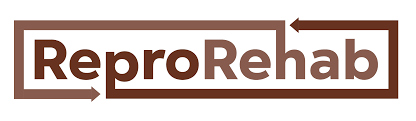